<h1 align="left">TSViT Inference</h1>

<p align="left"><i>PASTIS24 Dataset</i></p>

<p align="left">
  ITESM
  
  <a href="https://www.linkedin.com/in/juanrtato/">Juan Ricardo Albarracin B.</a>
  <br>
  <a href="">Luis Ángel Oporto Añacato.</a>
  <br>
  <a href="">David Alexis García Espinosa.</a>
  <br>
  <b>Last updated:</b> <i>15/05/2025</i>
  <br><br>
  <a target="_blank">
    <img src="https://github.com/QData/TextAttack/workflows/Github%20PyTest/badge.svg" alt="Testing">
  </a>
  <a href="https://img.shields.io/badge/version-0.1.0-blue.svg?cacheSeconds=2592000">
    <img src="https://img.shields.io/badge/version-0.1.0-blue.svg?cacheSeconds=2592000" alt="Version" height="18">
  </a>
</p><br>

In [1]:
CONFIG_PATH = '../datalake/config.json'
MODEL_PATH = '../datalake/TSVIT/best.pth'
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'scripts')))

In [2]:
import ast
import json
import torch
import random
import re
from utils import plot_sample_rgb, plot_seg_mask, mask_to_text
from tsvit import torch_utils, model_architecture
from pastis24 import get_dataloaders

In [3]:
device_ids = [0]
with open(CONFIG_PATH, 'r') as f:
    config = json.load(f)
device = torch_utils.get_device(device_ids, allow_cpu=False)
with open("../datalake/label_names_en.json", "r") as json_file:
    label_names_en = json.load(json_file)
with open("../datalake/colormap.txt", "r") as txt_file:
    colormap = txt_file.readlines()
colormap = [ast.literal_eval(line.strip().rstrip(',')) for line in colormap]

Dataset length: 36375
Dataset length: 12050


../datalake/PASTIS24/pickle24x24/30315_9.pickle
Sample shape: (60, 24, 24, 11)
Sample labels shape: (24, 24, 1)


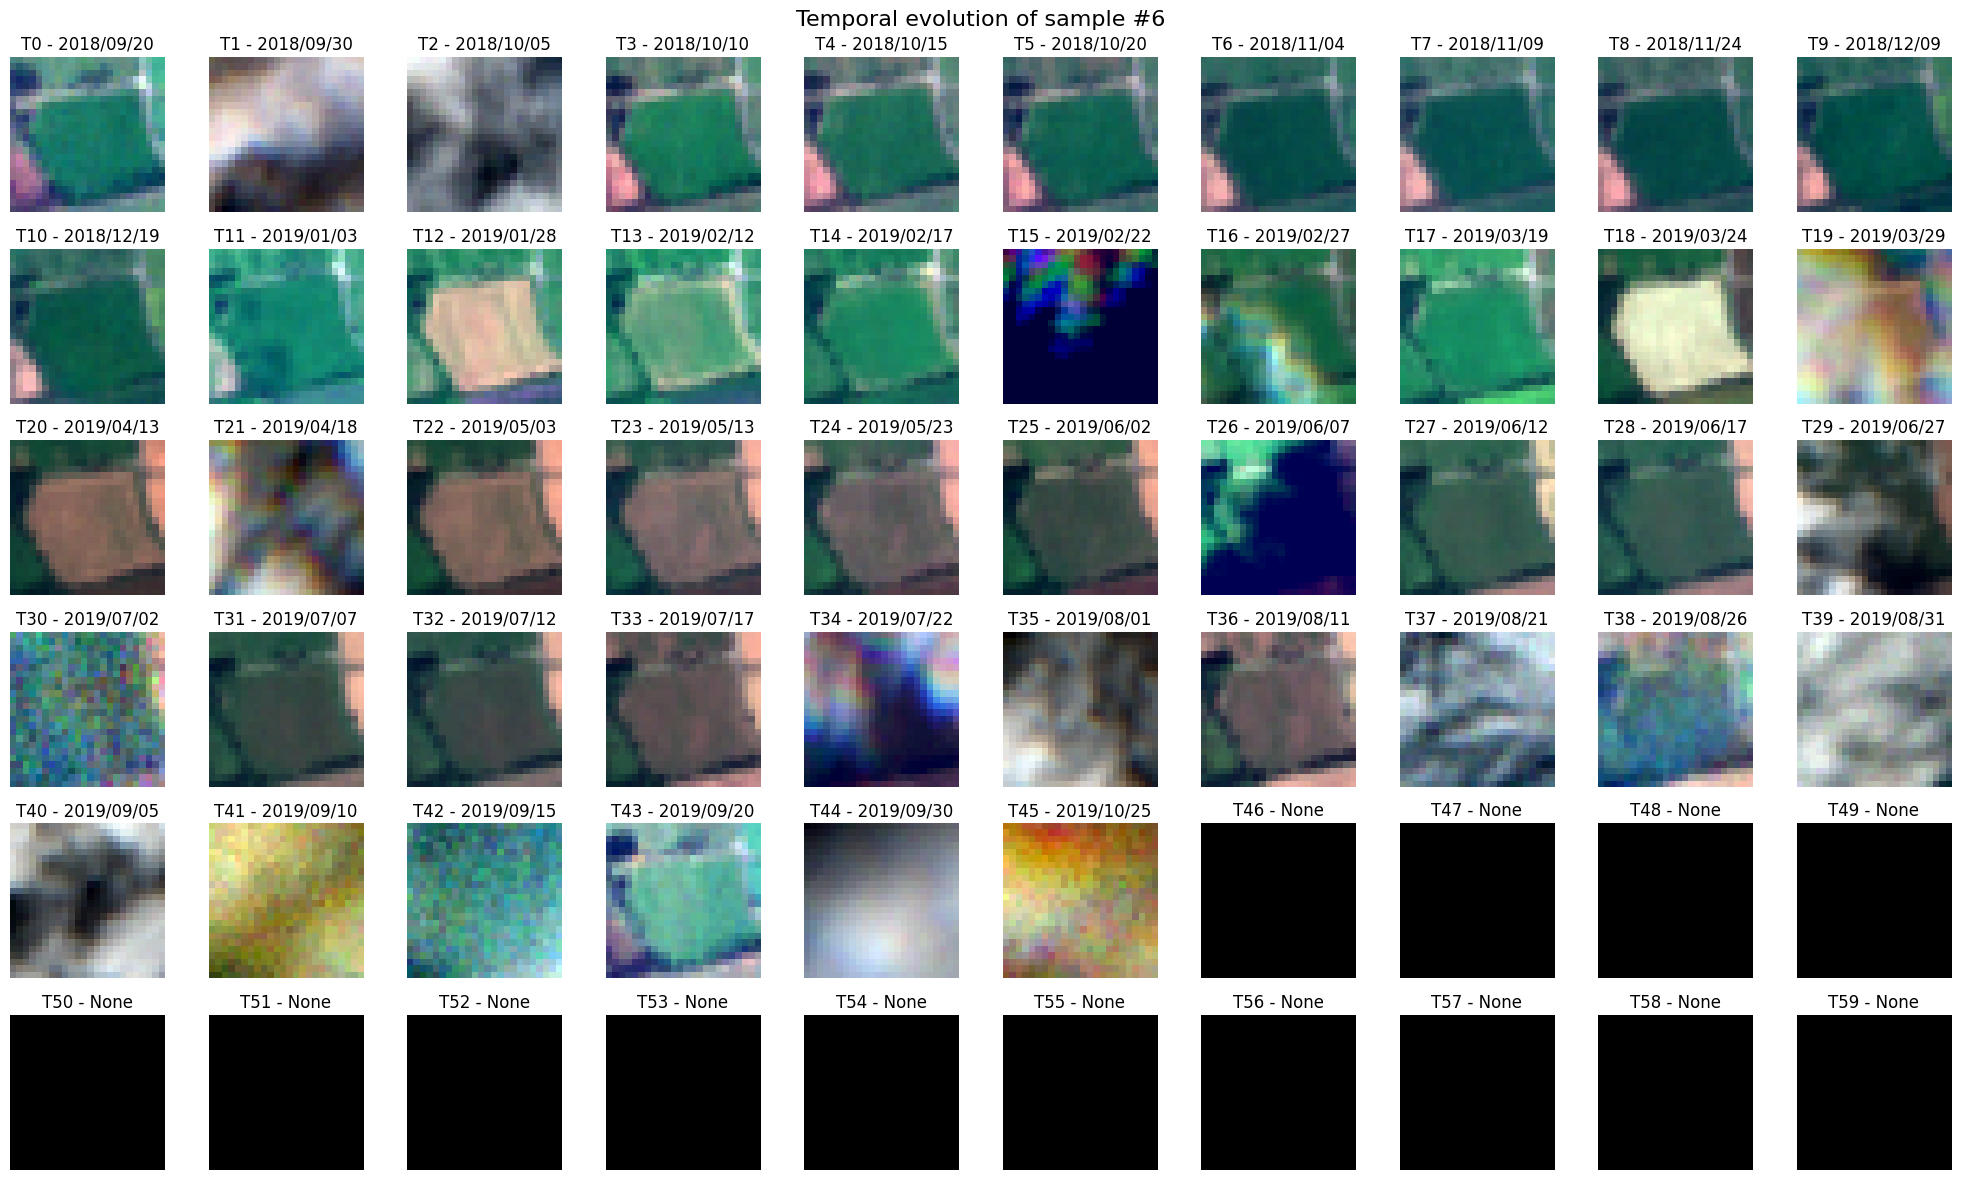

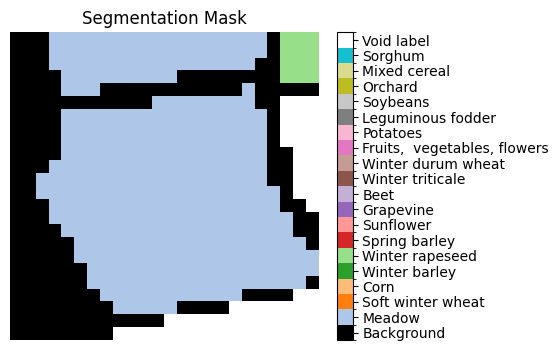

'This land shows the presence of the crop of meadow spanning approximately 33200 m2, winter rapeseed with an estimated size of 1200 m2, which forms an essential part of the total agricultural area: 57600 m2.\n'

In [6]:
dataloaders = get_dataloaders(config)
sample = next(iter(dataloaders['eval']))
sample_idx = random.randint(0, 16)
patch_id = 'UNKNOWN'
inputs = sample[0]['inputs']
labels = sample[0]['labels']
path_patch = sample[1][sample_idx]
print(path_patch)
match = re.match(r"(\d+)_\d+\.pickle", os.path.basename(path_patch))
if match:
    patch_id = match.group(1)
sample_labels = labels[sample_idx]
plot_sample_rgb(inputs, labels, patch_id, sample_idx=sample_idx)
plot_seg_mask(sample_labels[:, :, 0], colormap, label_names_en)
mask_to_text(sample_labels[:, :, 0], label_names_en)

In [ ]:
model = model_architecture.get_model(config, device)
model.load_state_dict(torch.load(MODEL_PATH))
model.eval()
print(model)
input_single = inputs[sample_idx].unsqueeze(0)
input_single = input_single.to(device)
with torch.no_grad():
    outputs = model(input_single)
predictions = torch.argmax(outputs, dim=1) 
predictions = predictions.squeeze(0).cpu().numpy()
predictions.shape

TSViT(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b t c (h p1) (w p2) -> (b h w) t (p1 p2 c)', p1=2, p2=2)
    (1): Linear(in_features=40, out_features=128, bias=True)
  )
  (to_temporal_embedding_input): Linear(in_features=366, out_features=128, bias=True)
  (temporal_transformer): Transformer(
    (layers): ModuleList(
      (0-3): 4 x ModuleList(
        (0): PreNorm(
          (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (fn): Attention(
            (to_qkv): Linear(in_features=128, out_features=384, bias=False)
            (to_out): Sequential(
              (0): Linear(in_features=128, out_features=128, bias=True)
              (1): Dropout(p=0.0, inplace=False)
            )
          )
        )
        (1): PreNorm(
          (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (fn): FeedForward(
            (net): Sequential(
              (0): Linear(in_features=128, out_features=512, bias=True)
              (1): GE

(24, 24)

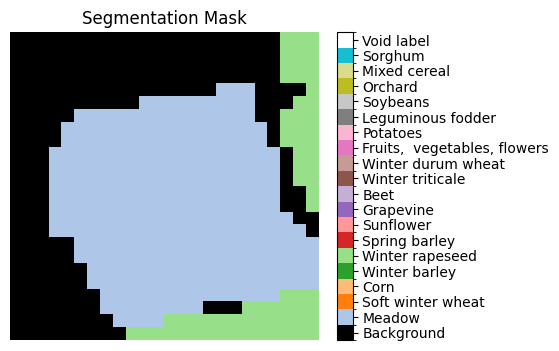

'The crop appearing in the image is meadow covering an area close to 28700 m2, winter rapeseed with a dimension close to 6800 m2, which corresponds to a relevant part of the cultivated area in this zone: 57600 m2.\n'

In [11]:
plot_seg_mask(predictions, colormap, label_names_en)
mask_to_text(predictions, label_names_en)